In [1]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from pathlib import Path
import pickle
import timeit
import sys, os

import pycoss.rod as rod
import pycoss.rod_on_sphere as rod_on_sphere

import pycoss.rod_on_sphere.interp.FFT as FFT
from pycoss.rod_on_sphere.helpers import *
from pycoss.rod_on_sphere.integrators import *
import pycoss.rod_on_sphere.helpers.plotting as plotting

In [2]:
np.seterr(all='raise')
import warnings
warnings.filterwarnings(action="error", category=np.ComplexWarning)

## Parameters

In [3]:
sim_name = 'OD_rod_closed'
output_folder = 'output'
scenario_name = 'test_scenario'
run_name = 'test'

In [4]:
dt = 1e-6
integrator = 'integrator_OD_FE'

In [5]:
L0 = 0.1
L = 1
dim = 3

Nm = 64*2
Mm = 128*2
Mm_render = Nm*2
Mm_save = Nm*2

# Generate curve

random_seed = 322
frame_rot_ampl = 0.
N_random_curve_modes = 2
mu_random_curve = 0
sigma_random_curve = 0.1

# System parameters

lmbd = 1

cn_k = np.array([1, 1, 1])*1e-2

# Simulation parameters

T = 0.2
taylor_tol = 1e-2

# Misc

N_save = 100
N_clock = 100
N_integrator_trials = int(1e4)

In [6]:
# Load arguments if running as a script
if sys.argv[1] == "args":
    params_pkl_path = sys.argv[2]
    args_params = pickle.load(open(params_pkl_path, 'rb'))

    for param_k, param_v in args_params.items():
        globals()[param_k] = param_v

## Initialise

#### Use Cosserat rod code to initialise rod on sphere

In [7]:
fft_Nm = Nm//2 + 1

us = FFT.grid(Mm, L0)
us_ext = np.linspace(0, L0, Mm+1, endpoint=True)
du = us[1] - us[0]

us_save = FFT.grid(Mm, L0)
us_save_ext = np.linspace(0, L0, Mm_save+1, endpoint=True)
du_save = us[1] - us[0]

In [8]:
path_handler = FFT.FourierHandler(dim, Nm, Mm, L0)
path_handler_render = FFT.FourierHandler(dim, Nm, Mm_render, L0)

In [9]:
frame_rot_th = np.sin(4*np.pi*path_handler_render.grid/L0) * frame_rot_ampl
frame_rot_phi = np.sin(4*np.pi*path_handler_render.grid/L0) * 0
frame_rot_psi = np.cos(4*np.pi*path_handler_render.grid/L0) * frame_rot_ampl

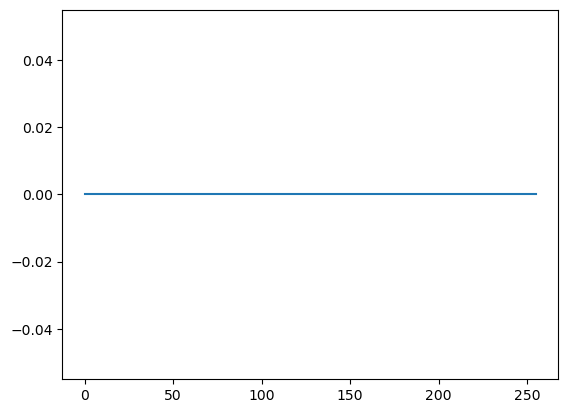

In [10]:
plt.plot(frame_rot_th)

In [11]:
if random_seed != -1:
    np.random.seed(random_seed)

In [12]:
def generate_random_periodic_function(dim, us, L, N, mu, sigma):
    fs = np.zeros((3, len(us)))
    dfs = np.zeros((3, len(us)))
    
    for i in range(dim):
        fs[i] += np.random.normal(mu, sigma)/2
        
        for j in range(1, N):
            a, b= np.random.normal(mu, sigma), np.random.normal(mu, sigma)
            
            fs[i] += a * np.cos((2*np.pi/L)*j*us) / (j*np.pi)
            fs[i] += b * np.sin((2*np.pi/L)*j*us) / (j*np.pi)
            
            dfs[i] += -(a * (2*np.pi/L)*j / (j*np.pi)) * np.sin((2*np.pi/L)*j*us)
            dfs[i] += (b * (2*np.pi/L)*j / (j*np.pi)) * np.cos((2*np.pi/L)*j*us)
            
    return fs, dfs

R0_raw, dR0_raw = generate_random_periodic_function(dim, path_handler_render.grid, L0,
                                       N_random_curve_modes, mu_random_curve, sigma_random_curve)

#fig = plt.figure(figsize=(10,10))
#plot_centerline(R0_raw, fig=fig)
#plt.show()

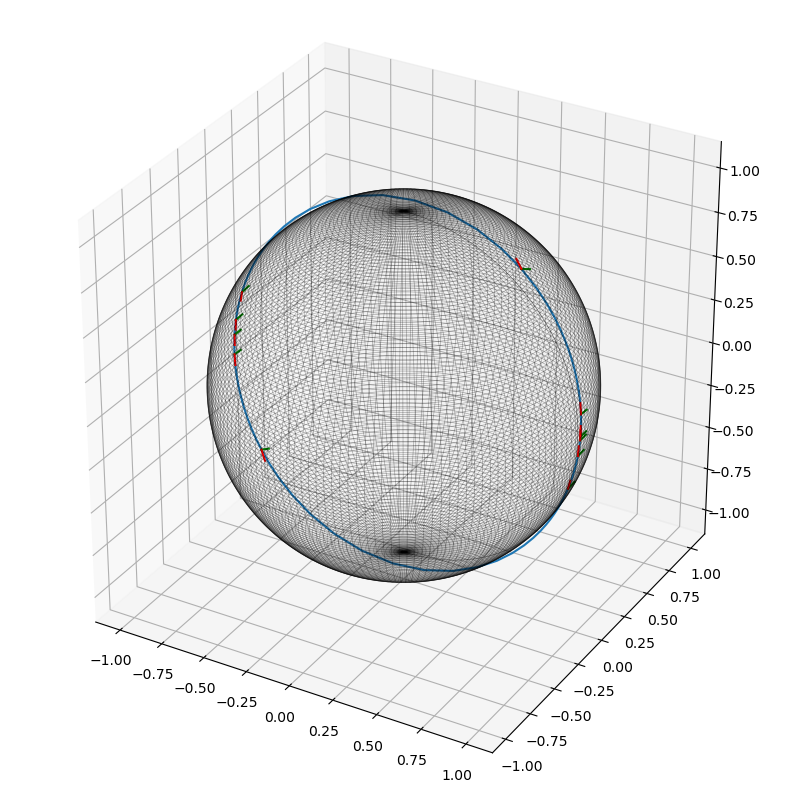

R_err: 0.004573755253137524
close_err: 2.2653649447321342e-05


In [13]:
c_th0, c_pi0, R_u0, E_u0, R_err0, close_err0 = rod.helpers.get_differential_invariants_from_curve(R0_raw, Nm, Mm,
                                                                    L0, L=L, err_tol=1e-1, dR=dR0_raw)

c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

th0_render = path_handler_render.iDT(c_th0_render)
pi0_render = path_handler_render.iDT(c_pi0_render)

# Rotate the frame

frame_rotation = eul2rot([frame_rot_th, frame_rot_phi, frame_rot_psi])

du_frame_rotation = np.zeros(frame_rotation.shape)
for i in range(3):
    du_frame_rotation[i,:] = path_handler_render.diff_f( frame_rotation[i,:] )
    
pi0_hat_render = hat_vec_to_mat(pi0_render)

transformed_pi0_hat_render = np.einsum('iju,kju->iku', du_frame_rotation, frame_rotation)
transformed_pi0_hat_render += np.einsum('iju,jku,lku->ilu', frame_rotation, pi0_hat_render, frame_rotation)
transformed_pi0_render = hat_mat_to_vec(transformed_pi0_hat_render)

transformed_th0_render = np.einsum('iju,ju->iu', frame_rotation, th0_render)

E_u0 = E_u0.dot(frame_rotation[...,0].T)

E_u0 = np.eye(3)

th0_render = transformed_th0_render
pi0_render = transformed_pi0_render

# Transform back to Fourier modes

c_th0_render = path_handler_render.DT(th0_render)
c_pi0_render = path_handler_render.DT(pi0_render)

c_th0 = path_handler.change_Mm(c_th0_render, Mm_render, Mm)
c_pi0 = path_handler.change_Mm(c_pi0_render, Mm_render, Mm)

c_th0_render = path_handler.change_Mm(c_th0, Mm, Mm_render)
c_pi0_render = path_handler.change_Mm(c_pi0, Mm, Mm_render)

th0_render = path_handler_render.iDT(c_th0_render)
pi0_render = path_handler_render.iDT(c_pi0_render)

# Plot rod

Fr0_u0 = construct_oriented_frame(R_u0, E_u0)
Fr0, rod_R0, E0 = rod.helpers.reconstruct_frame(th0_render, hat_vec_to_mat(pi0_render), L0, R_u0, E_u0)

R0 = E0[:,0,:]

fig = plt.figure(figsize=(10,10))
#rod.helpers.plotting.plot_centerline_and_frame(rod_R0, rod_E0, fig=fig, N_frame=10, frame_scale=0.03)
plotting.plot_centerline_and_frame(E0, fig=fig, N_frame=10, frame_scale=0.03)
plt.show()
plt.close()

print('R_err:', R_err0)
print('close_err:', close_err0)

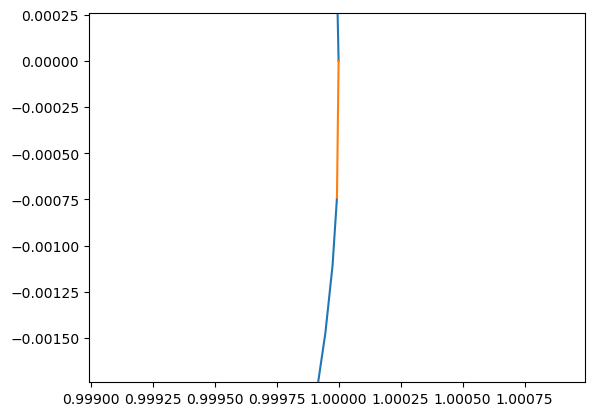

In [14]:
d = 1e-3
fig, ax = plt.subplots()
ax.plot(R0[0], R0[1])
ax.plot([R0[0,-1],R0[0,0]], [R0[1,-1],R0[1,0]])
ax.set_xlim(R0[0,-1]-d, R0[0,-1]+d)
ax.set_ylim(R0[1,-1]-d, R0[1,-1]+d)
plt.show()
plt.close()

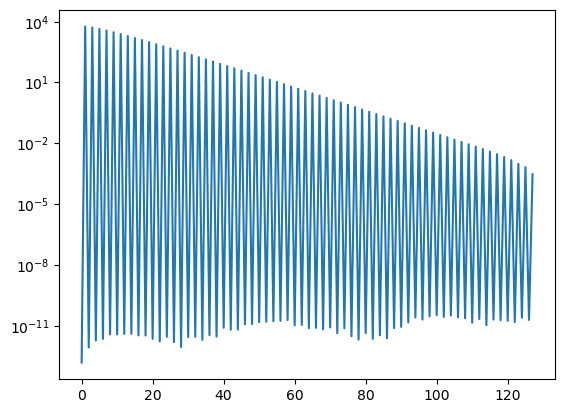

In [15]:
fig, ax = plt.subplots()
ax.plot(np.abs(c_pi0[2]))
ax.set_yscale('log')
plt.show()
plt.close()

In [16]:
c_X0 = c_pi0
c_X0_render = path_handler.change_Mm(c_X0, Mm, Mm_render)
X0_render = path_handler_render.iDT(c_X0_render)

Fr0_u0 = np.eye(3)
#R0, E0 = reconstruct_frame(hat_vec_to_mat(X0_render), L0, Fr0_u0)
R0, E0 = reconstruct_curve(c_X0, Fr0_u0, Mm, Mm_save, path_handler_render)

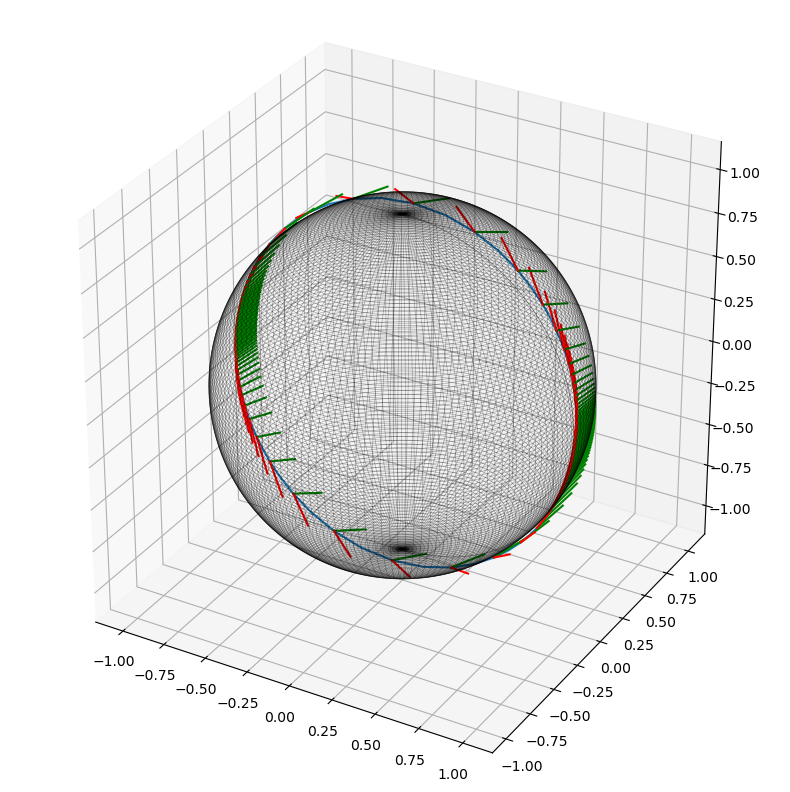

In [17]:
fig = plt.figure(figsize=(10,10))
#rod.helpers.plotting.plot_centerline_and_frame(rod_R0, rod_E0, fig=fig, N_frame=10, frame_scale=0.03)
plotting.plot_centerline_and_frame(E0, fig=fig, N_frame=100, frame_scale=0.1)
plt.show()
plt.close()

## Define dynamics

In [18]:
def compute_Q(t, X, out=None):
    Q = np.einsum('i,iu->iu', cn_k, X, out=out)
    Q[1] += cn_k[1]
    return Q

def compute_U(us, X):
    U = cn_k[0]*(X[0])**2 + cn_k[1]*(X[1]+0.01)**2 + cn_k[2]*(X[2])**2
    U = np.trapz(U, us)*0.5
    return U

In [19]:
U0 = compute_U(path_handler_render.grid_ext,
                      path_handler_render.get_ext_f(X0_render, c_X0_render))

print('U:', U0)

U: 8.298474905426275


## Simulate

In [20]:
params = {
    'T' : T,
    'dt' : dt,
    'taylor_tol' : taylor_tol,
    
    'lmbd' : lmbd,
    
    'path_handler' : path_handler,
    'path_handler_render' : path_handler_render,
    
    'c_X0' : c_X0,
    'Fr0_u0' : Fr0_u0,
    
    'Q' : compute_Q,
    
    'U' : compute_U,
    
    'N_save' : N_save,
    'Mm_save' : Mm_save,
    
    'N_clock' : N_clock,
    
    'save_ts' : False,
}

In [21]:
params['integrator'] = globals()[integrator]
sim_res = rod_on_sphere.sim.OD_simulate(params)

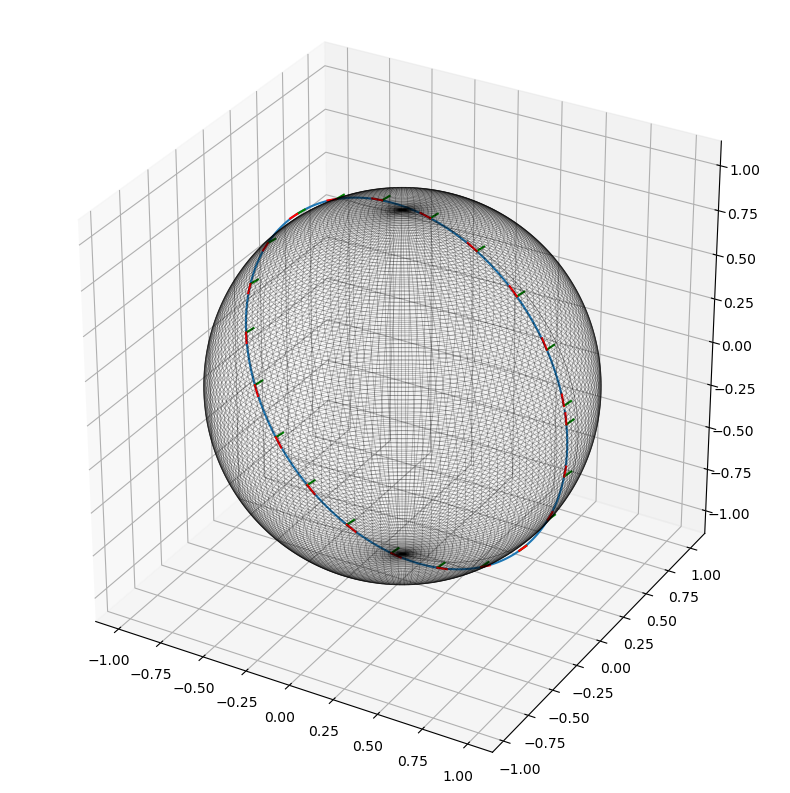

In [22]:
E = sim_res['Ef']

fig = plt.figure(figsize=(10,10))
#rod.helpers.plotting.plot_centerline_and_frame(rod_R0, rod_E0, fig=fig, N_frame=10, frame_scale=0.03)
plotting.plot_centerline_and_frame(E, fig=fig, N_frame=20, frame_scale=0.03)
plt.show()
plt.close()

In [23]:
sim_res.keys()

dict_keys(['ts', 'Nt', 'us', 'us_ext', 'c_X', 'Fr_u0', 'X0', 'X', 'N', 'U', 'Rf', 'Ef', 'sim_run_time', 'sim_run_time2', 'saved_R', 'saved_E', 'saved_ts'])

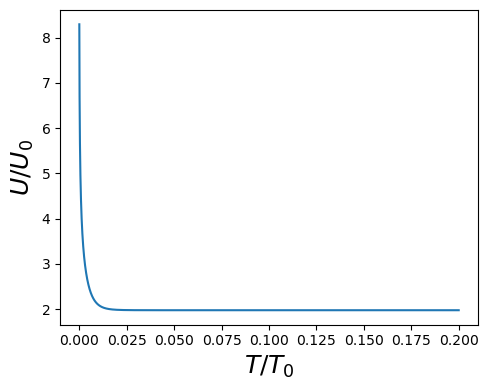

In [24]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

ts = np.linspace(0, T, len(sim_res['U']))
ax.plot(ts, sim_res['U'])

ax.set_ylabel(r'$U/U_0$', fontsize=18)
ax.set_xlabel(r'$T/T_0$',  fontsize=18)

plt.tight_layout()

plt.savefig('rod_on_sphere_U.pdf')

plt.show()

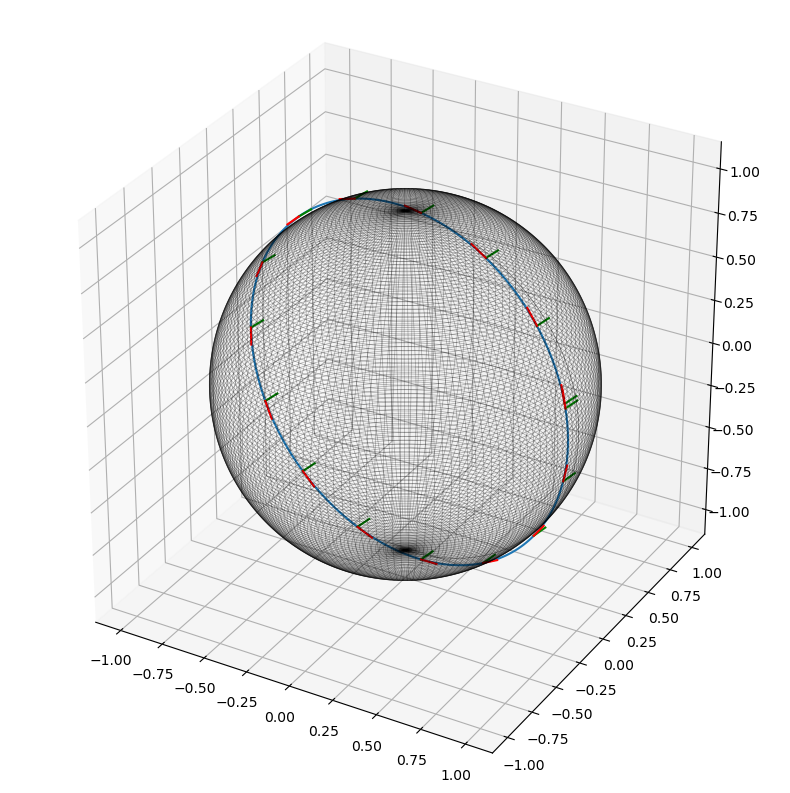

In [25]:
R = sim_res['saved_R'][0]
d = max(R[0]) - np.min(R[0])
d = max(d, np.max(R[1]) - np.min(R[1]))
d = max(d, np.max(R[2]) - np.min(R[2]))
frame_scale = d/20
N_frame = 15

plotting.vid_centerline_and_frame_3D(sim_res['saved_E'],
                            save_name='video.mp4', frame_scale=frame_scale, N_frame=N_frame)
plt.show()
plt.close()

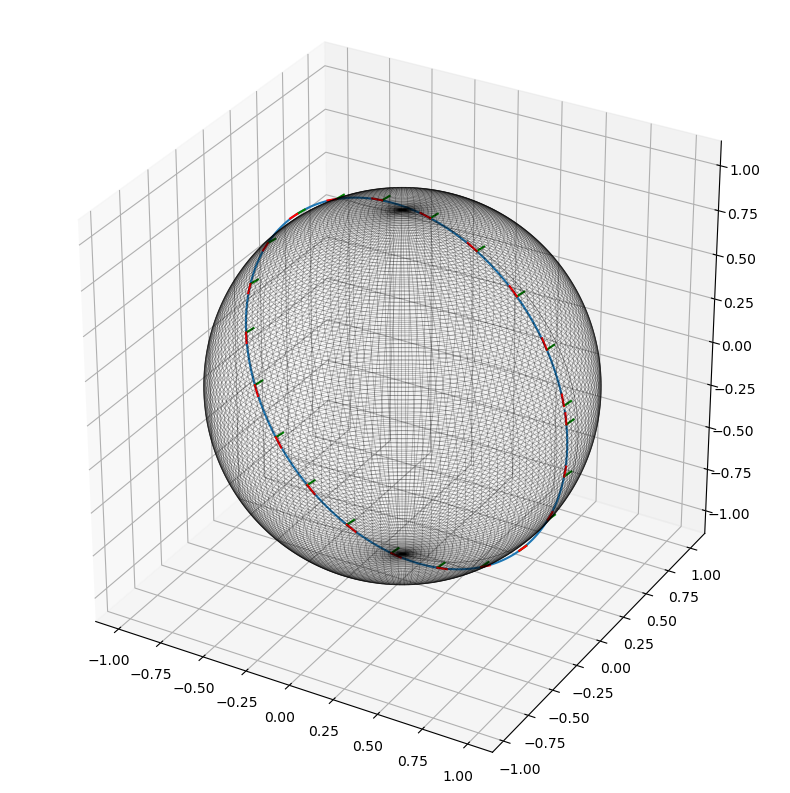

In [26]:
E = sim_res['Ef']

fig = plt.figure(figsize=(10,10))
#rod.helpers.plotting.plot_centerline_and_frame(rod_R0, rod_E0, fig=fig, N_frame=10, frame_scale=0.03)
plotting.plot_centerline_and_frame(E, fig=fig, N_frame=20, frame_scale=0.03)

plt.show()
plt.close()

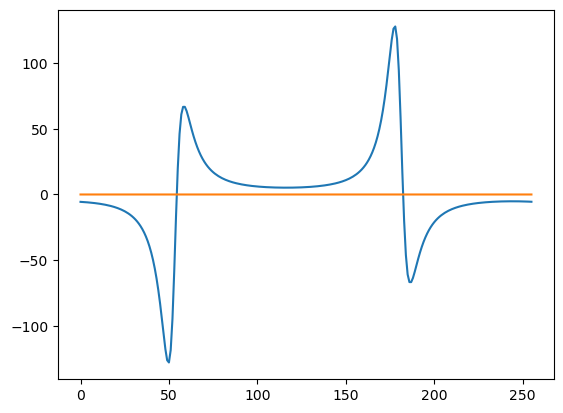

In [27]:
plt.plot(sim_res['X0'][0])
plt.plot(sim_res['X'][0])

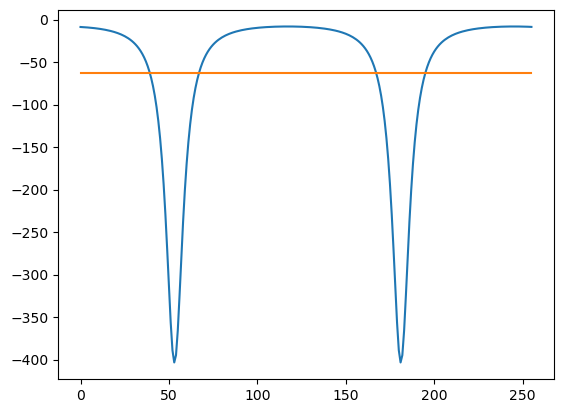

In [28]:
plt.plot(sim_res['X0'][1])
plt.plot(sim_res['X'][1])

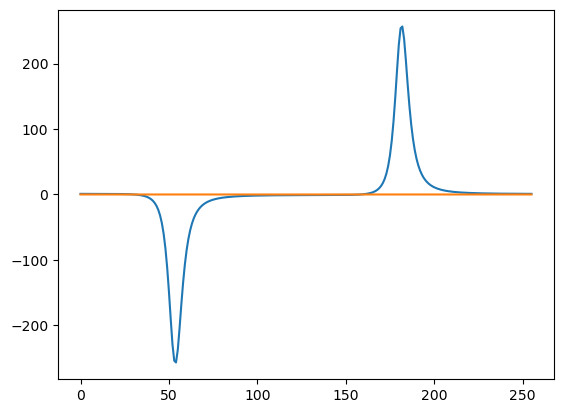

In [29]:
plt.plot(sim_res['X0'][2])
plt.plot(sim_res['X'][2])

## Saving results

In [30]:
N_tube = 20
tube_width = 0.1
    
_E = np.zeros((3,3,E.shape[-1]+1))
_E[:,:,:-1] = E0
_E[:,:,-1] = _E[:,:,0]
r, e2, e3 = _E[:,0], _E[:,1], _E[:,2]

e2 *= tube_width
e3 *= tube_width

r.T.astype('float32').tofile('rod0_r.dat')
e2.T.astype('float32').tofile('rod0_e2.dat')
e3.T.astype('float32').tofile('rod0_e3.dat')

tube_b1 = r + e2
tube_b2 = r - e2
tube_b1.T.astype('float32').tofile('rod0_tube_b1.dat')
tube_b2.T.astype('float32').tofile('rod0_tube_b2.dat')

In [31]:
N_tube = 20
tube_width = 0.1
    
_E = np.zeros((3,3,E.shape[-1]+1))
_E[:,:,:-1] = E
_E[:,:,-1] = _E[:,:,0]
r, e2, e3 = _E[:,0], _E[:,1], _E[:,2]

e2 *= tube_width
e3 *= tube_width

r.T.astype('float32').tofile('rod_r.dat')
e2.T.astype('float32').tofile('rod_e2.dat')
e3.T.astype('float32').tofile('rod_e3.dat')

tube_b1 = r + e2
tube_b2 = r - e2
tube_b1.T.astype('float32').tofile('rod_tube_b1.dat')
tube_b2.T.astype('float32').tofile('rod_tube_b2.dat')